# Variogram Point Cloud - tutorial

## Table of Contents:

1. Read point data,
2. Create variogram point cloud,
3. Detect and remove outliers.
4. Calculate experimental semivariance from point cloud.

## Level: Basic

## Changelog

| Date       | Change description                                                                                                                                                     | Author                     |
|------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------|
| 2022-08-17 | Updated to the version 0.3.0                                                                                                                                           | @SimonMolinsky             |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function                                                                                                                | @SimonMolinsky             |
| 2021-10-13 | Refactored TheoreticalSemivariogram (name change of class attribute) and refactored `calc_semivariance_from_pt_cloud()` function to protect calculations from `NaN's`. | @ethmtrgt & @SimonMolinsky |
| 2021-08-22 | Refactored the Outlier Removal algorithm - quantile based algorithm                                                                                                    | @SimonMolinsky             |
| 2021-08-10 | Refactored the Outlier Removal algorithm                                                                                                                               | @SimonMolinsky             |
| 2021-05-11 | Refactored TheoreticalSemivariogram class                                                                                                                              | @SimonMolinsky             |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data.                                                                                    | @SimonMolinsky             |

## Introduction

In this tutorial we will learn how to read and prepare data for semivariogram modeling, how to manually find the best step size between lags and how to detect outliers in our data which can affect final semivariogram.

Variogram Point Cloud analysis is an additional, basic data preparation step which may save you a lot of headache with more sophisticated analysis. You should learn about Variogram Point Cloud analysis before you move on to the semivariogram estimation and semivariogram fitting operations.

We use: 

- for point 1 and 2: DEM data which is stored in a file `sample_data/point_data/poland_dem_gorzow_wielkopolski`,
- for point 3: Breast cancer rates data is stored in the shapefile in folder `sample_data/areal_data/breast_cancer_rate_per_area_2.shp`.

## Import packages

In [9]:
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

from pyinterpolate import Blocks
from pyinterpolate.io import read_txt
from pyinterpolate.distance.distance import calc_point_to_point_distance
from pyinterpolate.variogram.empirical.variogram_cloud import VariogramCloud
from pyinterpolate.variogram.empirical.experimental_variogram import build_experimental_variogram

## 1) Read point data

In [2]:
dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')

In [3]:
# Look into a first few lines of data

dem[:10, :]

array([[2.37685325e+05, 5.45416708e+05, 5.12545509e+01],
       [2.37674140e+05, 5.45209671e+05, 4.89582825e+01],
       [2.37449255e+05, 5.41045935e+05, 1.68178635e+01],
       [2.37320090e+05, 5.38653518e+05, 1.62939053e+01],
       [2.37187238e+05, 5.36192094e+05, 1.65406628e+01],
       [2.37056908e+05, 5.33776683e+05, 1.94509335e+01],
       [2.37050703e+05, 5.33661664e+05, 1.92426758e+01],
       [2.36890637e+05, 5.30694166e+05, 4.56620102e+01],
       [2.36841016e+05, 5.29774013e+05, 3.37260437e+01],
       [2.36826130e+05, 5.29497967e+05, 3.55447350e+01]])

## 2) Set proper lag size with variogram cloud histogram

In this step we generate Variogram Point Cloud. We calculate it for 16 lags and test different cloud variogram visualization methods.

In [4]:
# Create analysis parameters

# Check max distance between points
distances = calc_point_to_point_distance(dem[:, :-1])
maximum_range = np.max(distances) / 2

number_of_lags = 16
step_size = maximum_range / number_of_lags

vc = VariogramCloud(input_array=dem, step_size=step_size, max_range=maximum_range)

Now we check how many points are grouped for each lag:

In [5]:
for idx, _lag in enumerate(vc.lags):
    print(f'Lag {_lag} has {vc.points_per_lag[idx]} point pairs.')

Lag 934.6034381080927 has 296822 point pairs.
Lag 1869.2068762161855 has 830918 point pairs.
Lag 2803.8103143242784 has 1299328 point pairs.
Lag 3738.413752432371 has 1707280 point pairs.
Lag 4673.017190540464 has 2051616 point pairs.
Lag 5607.620628648557 has 2343114 point pairs.
Lag 6542.224066756649 has 2562464 point pairs.
Lag 7476.827504864742 has 2734920 point pairs.
Lag 8411.430942972835 has 2849234 point pairs.
Lag 9346.034381080928 has 2920514 point pairs.
Lag 10280.637819189022 has 2948446 point pairs.
Lag 11215.241257297113 has 2914808 point pairs.
Lag 12149.844695405207 has 2838740 point pairs.
Lag 13084.448133513299 has 2714790 point pairs.
Lag 14019.051571621392 has 2559140 point pairs.


As we see, there is a lot of points per lag! Data is probably messy, but to be sure, we must check its distribution. What are those **points per lag**? It is a number set of semivariances between all point pairs within a specific lag. This information may be useful to know if there are any undersampled ranges, and we can change `step_size` accordingly (to avoid situation, where a lag has the order of magnitude less point pairs than other lags).

With the information about data density, we can take a closer look into data distribution. The `VariogramCloud` class has three types of plots that can be used for analysis:

1. Scatter plot (per lag). It shows general dispersion of semivariances, but it is hard to read more from this type of plot.
2. Box plot. It shows dispersion and quartiles of semivariances per lag. It is a great tool to detect outliers. We can check distribution differences per lag, and their deviation from normality or skewness (slightly harder task).
3. Violin plot. It is a box plot on steroids. We can read all information as from box plot plus we see a distribution of semivariances per lag.

Let's plot them all. First, is scatter plot. It can take a while (we have thousands of point pairs), so now it is a good time to prepare a beverage.

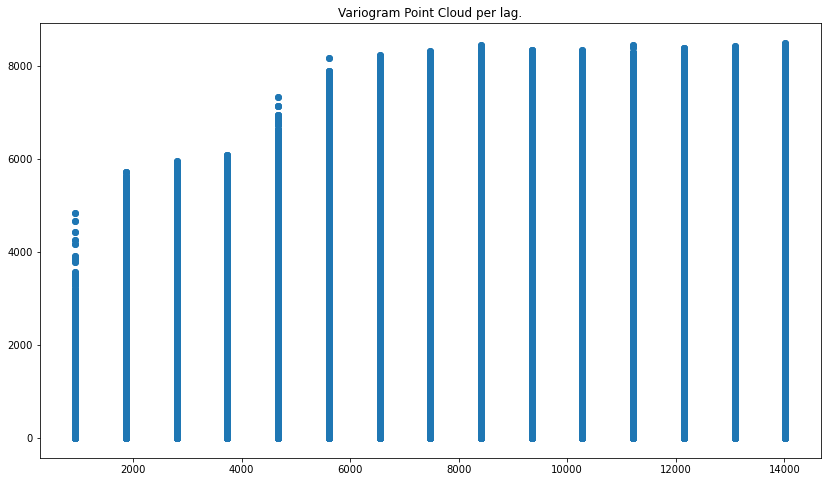

In [6]:
vc.plot('scatter')

The output per lag is dense and we cannot distinguish a single semivariance values from a scatter plot. But, we can follow a general trend and see maxima on the plot. We can make it better, if we use a box plot instead:

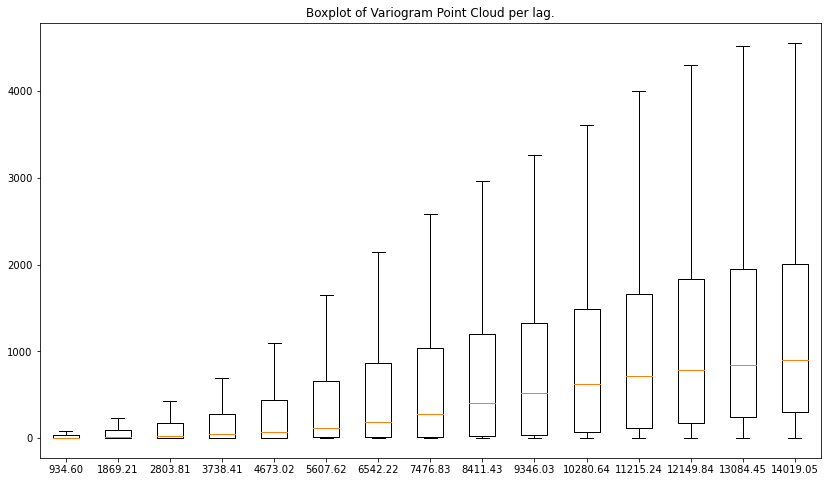

In [7]:
vc.plot('box')

The orange line in a middle of each box represents median (50%) value per lag. The trend is more visible if we look into it. What else can be seen here?

1. Dispersion of values is greater with a distance, but at the same time median and the **3rd quartile** of semivariance values is rising (**3rd quartile** is plotted as a horizontal line on a top of a box.
2. The maximum value rises with a distance (it is a horizontal line on a top of a whisker).
3. Data is skewed towards lower values of semivariance. Why? Because median is closer to the bottom of a box than to the center or the top.
4. The **1st quartile** (25% of the lowest values) rises with a lags.

We could stop our analysis here, but there is a better option to analyze data distribution than a box plot. We can use a violin plot:

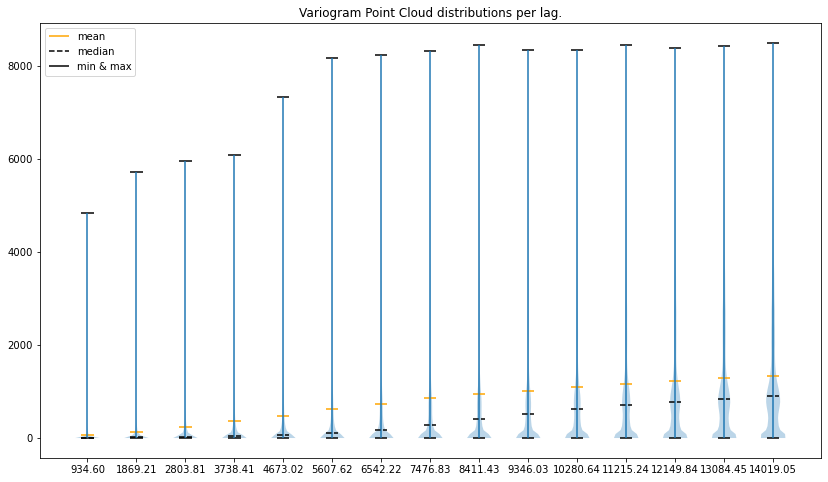

In [8]:
vc.plot('violin')

The violin plot supports our earlier ideas but it shows additional pattern that we should be aware of. For a distant lags, a distribution starts to be multimodal. We see one mode around a very low values of semivariance and another mode close to the 1st quartile. Multimodality may affect our final outcomes, and maybe it tells us that there are more than 1 levels of spatial dependency?

There is elephant in the room that we didn't cover yet. Our data is literally pulled up with outliers. Do you see long whiskers on a top of every distribution? We can let it be, but maybe it is a better idea to slightly clean those results before we start Kriging? In the next paragraph, we will detect and remove outliers from a block dataset.

## 3) Detect and remove outliers

With idea how Variogram Point Cloud works we can detect and "remove" outliers from our dataset. We use for it other dataset which represents the breast cancer rates in counties of Northeastern part of the U.S. Each county will be transformed into its centroid. Those centroids are not evenly spaced and we can expect that for some number of steps dataset may be modeled incorrectly.

In [10]:
# Read and prepare data

DATASET = 'samples/regularization/cancer_data.gpkg'
POLYGON_LAYER = 'areas'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'
MAX_RANGE = 400000
STEP_SIZE = 40000

AREAL_INPUT = Blocks()
AREAL_INPUT.from_file(DATASET, value_col=POLYGON_VALUE, index_col=POLYGON_ID, layer_name=POLYGON_LAYER)

AREAL_INPUT.data.head()

,FIPS,geometry,rate,centroid.x,centroid.y
0,25019,"MULTIPOLYGON (((2115688.816 556471.240, 211569...",192.2,2.132630e+06,557971.155949
1,36121,"POLYGON ((1419423.430 564830.379, 1419729.721 ...",166.8,1.442153e+06,550673.935704
2,33001,"MULTIPOLYGON (((1937530.728 779787.978, 193751...",157.4,1.958207e+06,766008.383446
3,25007,"MULTIPOLYGON (((2074073.532 539159.504, 207411...",156.7,2.082188e+06,556830.822367
4,25001,"MULTIPOLYGON (((2095343.207 637424.961, 209528...",155.3,2.100747e+06,600235.845891


In [12]:
areal_centroids = AREAL_INPUT.data[['centroid.x', 'centroid.y', 'rate']].values

In [16]:
# Create analysis parameters

# Check max distance between points

distances = calc_point_to_point_distance(areal_centroids[:, :-1])
maximum_range = np.max(distances) / 2

number_of_lags = 8
step_size = maximum_range / number_of_lags

vc = VariogramCloud(input_array=areal_centroids, step_size=step_size, max_range=maximum_range)

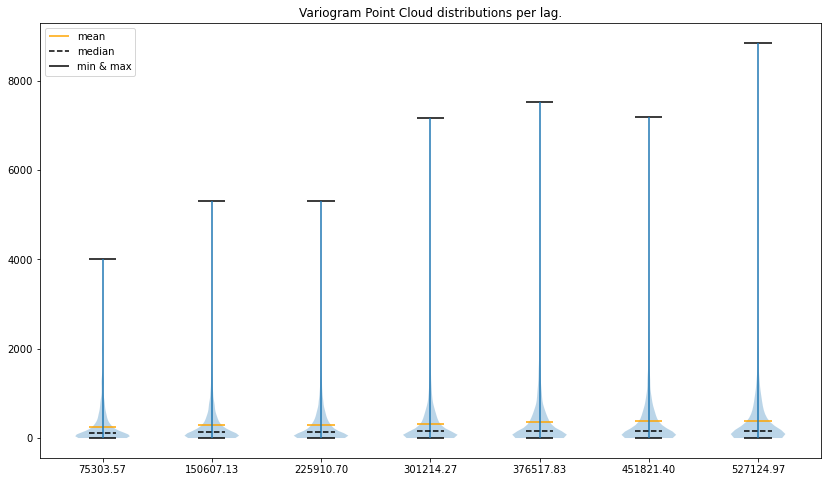

In [17]:
vc.plot('violin')

In [18]:
for idx, _lag in enumerate(vc.lags):
    print(f'Lag {_lag} has {vc.points_per_lag[idx]} point pairs.')

Lag 75303.56650292415 has 1936 point pairs.
Lag 150607.1330058483 has 4740 point pairs.
Lag 225910.69950877246 has 6532 point pairs.
Lag 301214.2660116966 has 7254 point pairs.
Lag 376517.83251462074 has 7066 point pairs.
Lag 451821.39901754487 has 5904 point pairs.
Lag 527124.9655204691 has 4494 point pairs.


The initial data check shows that there are probably outliers in the upper part of a dataset (that's why our dataset has 

### Clarification

1. There are some outliers in a dataset! To get rid of them we will remove all TOP values which are further away from the mean than 2 standard deviations (for each lag).

In [14]:
cloud_without_outliers = remove_outliers(variogram_clouds[2], exclude_part='top')

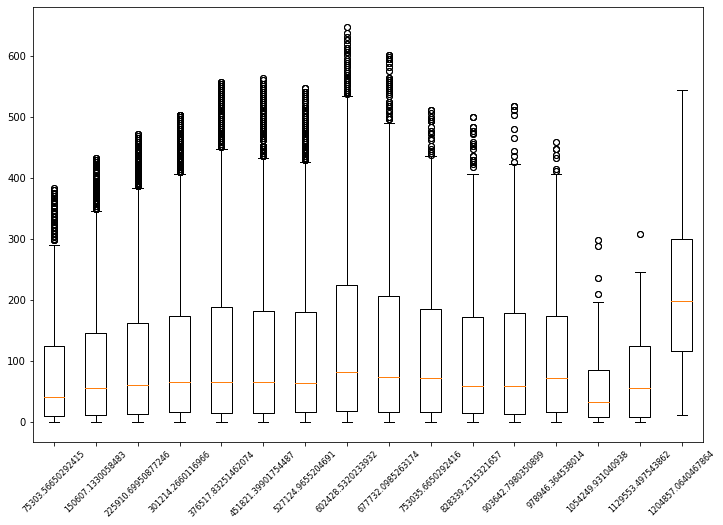

In [15]:
show_variogram_cloud(cloud_without_outliers, figsize=(12, 8))

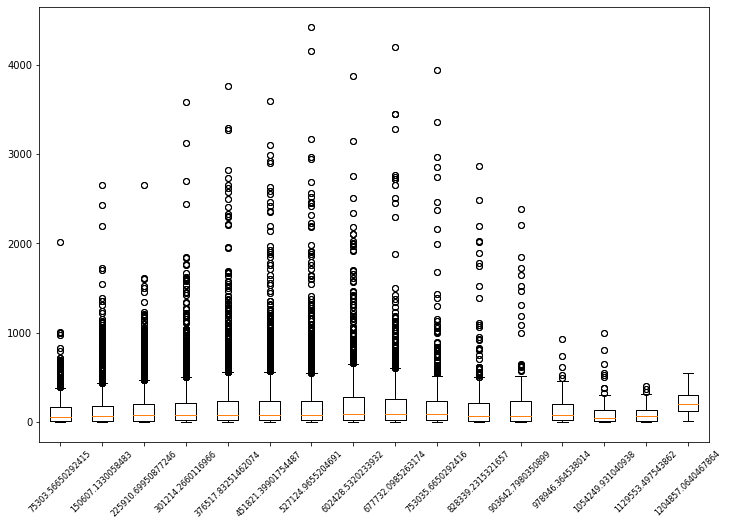

In [16]:
show_variogram_cloud(variogram_clouds[2], figsize=(12, 8))

### Clarification:

Compare y axis of two figures above. Upper figure is cleaned from outliers and lower has those values. Maximum on y axis for the upper is 1000, for the lower is 5000. Experimental semivariogram smooths outliers from initial dataset and you may compare y axis of experimental semivariogram with both variogram clouds to see it.

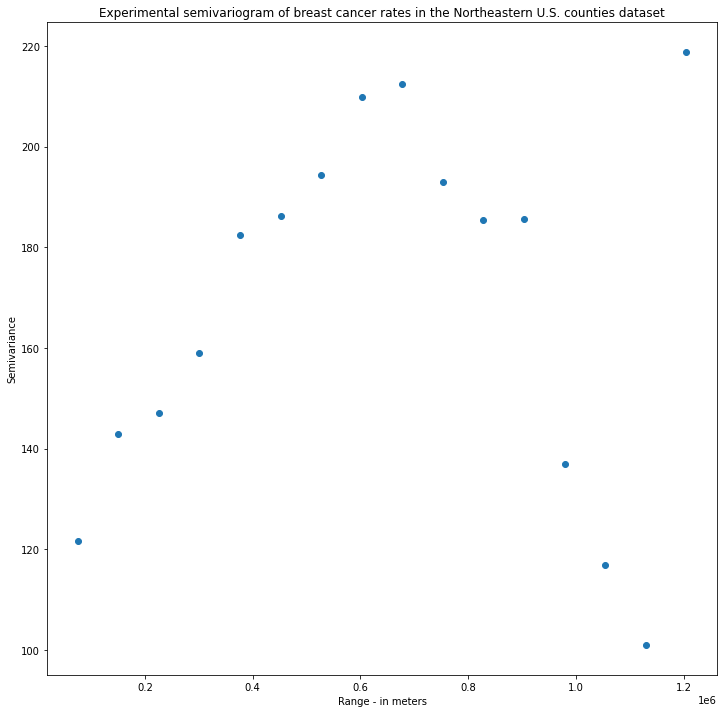

In [17]:
# Experimental semivariogram

search_radius = step_sizes[1]
max_range = maximum_range

exp_semivar = calculate_semivariance(data=areal_centroids, step_size=step_sizes[2], max_range=maximum_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1], 'o')
plt.title('Experimental semivariogram of breast cancer rates in the Northeastern U.S. counties dataset')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

## 4) Calculate experimental semivariogram from point cloud.

You may calculate semivariogram directly, like in the cell above, or from the point cloud. Latter is useful when you perform outliers detection and you remove some of them. Let's check it for our dataset without outliers.

In [18]:
experimental_semivariogram_from_pt_cloud = calc_semivariance_from_pt_cloud(cloud_without_outliers)

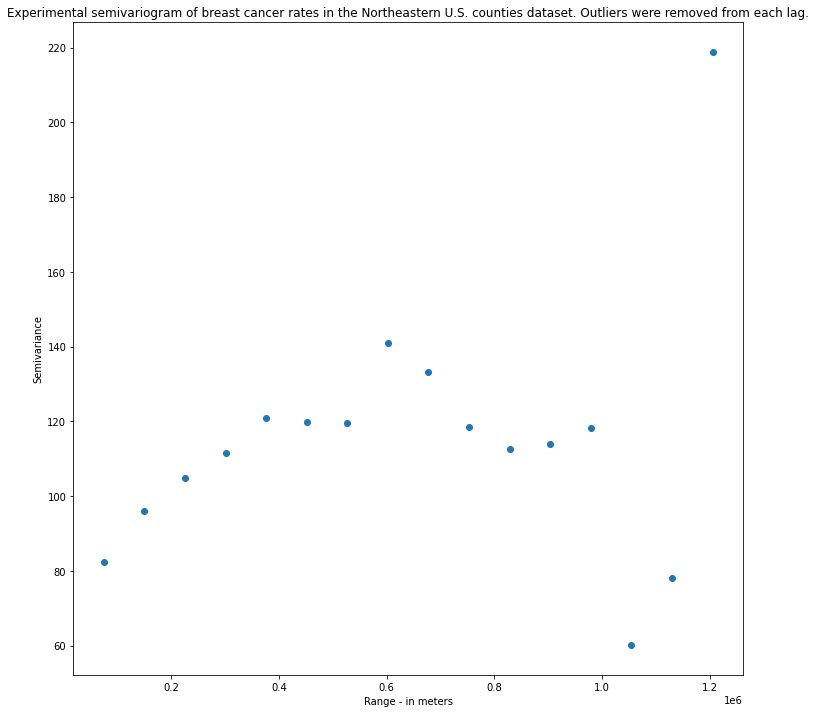

In [19]:
# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(experimental_semivariogram_from_pt_cloud[:, 0], experimental_semivariogram_from_pt_cloud[:, 1], 'o')
plt.title('Experimental semivariogram of breast cancer rates in the Northeastern U.S. counties dataset. Outliers were removed from each lag.')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

As you may noticed, shape of the semivariogram is preserved but values of semivariance are much smaller for the data without outliers.

## 5) What next?

From this point you may look into **Outliers and Their Influence on the Final Model (Intermediate)** notebook where we are exploring the variogram point clouds further.

---